In [75]:
from model import Model
import sys
import torch
sys.path += ['../']
from data_loader import get_loader
from train_evaluate import *
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

# for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
path_cat2ind = '../../data/cat2ind.csv'
path_word_count = '../../data/word2count.txt'

#load index to category mapping
ind2category = {}
word2ind = {'PAD':0, 'OOV':1}
with open(path_cat2ind, encoding='utf-8') as f:
    for line in f:
        mapping = line.split(',')
        ind2category[int(mapping[1])] = mapping[0]


#load word to index mapping
count = 2
with open(path_word_count) as f:
    for line in f:
        mapping = line.split('\t')
        word2ind[mapping[0]] = count
        count+=1

vocab_size = count

In [3]:
model = Model(embedding_size=100, hidden_size=128, d_a=50, number_attention=5,
              vocab_size=vocab_size, number_classes=len(ind2category), regularization_coeff=0.01, device=device)
model = model.to(device)

In [4]:
path_checkpoints = '../../checkpoints_structured_self_attention'

path_documents_train = '../../data/train_documents.txt'
path_labels_train = '../../data/train_labels.txt'
path_documents_valid = '../../data/valid_documents.txt'
path_labels_valid = '../../data/valid_labels.txt'
trainModel(model, path_documents_train, path_labels_train, path_documents_valid, path_labels_valid,
           word2ind, path_checkpoints, n_epochs=10, printEvery=300)

-----EPOCH1-----
Iteration: 300, Time: 16.6517 s, training loss: 1.0997
Iteration: 600, Time: 33.0798 s, training loss: 0.4830
Iteration: 900, Time: 49.3726 s, training loss: 0.3741
Iteration: 1200, Time: 65.5938 s, training loss: 0.3385
Iteration: 1500, Time: 81.4252 s, training loss: 0.3089
Epoch 1 done: training_accuracy = 0.951, validation_accuracy = 0.910
validation accuracy improved: saving checkpoint...
checkpoint saved to: ../../checkpoints_structured_self_attention/best_checkpoint.pt
-----EPOCH2-----
Iteration: 1800, Time: 172.6740 s, training loss: 0.2651
Iteration: 2100, Time: 188.7288 s, training loss: 0.1861
Iteration: 2400, Time: 205.3096 s, training loss: 0.1650
Iteration: 2700, Time: 221.4497 s, training loss: 0.1529
Iteration: 3000, Time: 237.1601 s, training loss: 0.1599
Epoch 2 done: training_accuracy = 0.984, validation_accuracy = 0.917
validation accuracy improved: saving checkpoint...
checkpoint saved to: ../../checkpoints_structured_self_attention/best_checkpoint

In [10]:
def load_model(model_path):
    my_model = Model(embedding_size=100, hidden_size=128, d_a=50, number_attention=5,
                           vocab_size=vocab_size, number_classes=len(ind2category),
                           regularization_coeff=0.01, device=device)
    my_model.load_state_dict(torch.load(model_path,
                                        map_location=torch.device(device)))
    return my_model

my_model = load_model(os.path.join(path_checkpoints, 'model.pt'))
my_model = my_model.to(device)

In [14]:
path_documents_test = '../../data/test_documents.txt'
path_labels_test = '../../data/test_labels.txt'

loader = get_loader(path_documents_test, path_labels_test, word2ind, str(device), batch_size=512)
evaluate(my_model, loader)

0.9107979910714287

In [29]:
loader = get_loader(path_documents_test, path_labels_test, word2ind, str(device), batch_size=1)

In [88]:
b = next(iter(loader))
tensor = b[0].permute(1,0)
print(tensor, b[1])

ind2word = {el[1]:el[0] for el in list(word2ind.items())}
# sequence to text
text = [ind2word.get(ind.item()) for ind in tensor[0]]
# reshaped for a better display for arabic text
text_reshaped = [get_display(arabic_reshaper.reshape(el)) for el in text]
print((' ').join(text))

tensor([[ 4344,   306,    78,  4958, 14774,  4850,  2483,     3,   122,     3,
          2688,  3666,    28,   357,   250,  2161, 10367,   783, 17758,     2,
           336,    19,   192,   934,     3,    90,   345,   186,   233,     6,
          1510,    10,   111,  1596,    15,   839,   201,   845,  2452,     6,
           166, 20288,   826, 36690,    33, 53934,  1144,    13,  8266,  1371,
             7,   770,  1198,  5918, 65302,     4,  1456, 17758,   282,     9,
            52,     2,  1215,  1144,    13,     8, 17033,  4344,  9317,     3,
           830,  5520,   154, 27853,   457,     3,  7527, 11582,    19,   833,
             9, 21010,     5]], device='cuda:0') tensor([1], device='cuda:0')
استهدفت الولايات المتحدة عضوا بارزا بتنظيم القاعدة في سوريا في ضربة جوية اليوم الاثنين وما زالت تقيم نتائج الضربة ، بحسب ما اعلن مسؤول في وزارة الدفاع الاميركية ل " رويترز ". واضاف المسؤول الذي طلب عدم نشر اسمه " لن نناقش عمليات بعينها او ننشر معلومات عن الضربات الجوية على اهداف مهمة لحين 

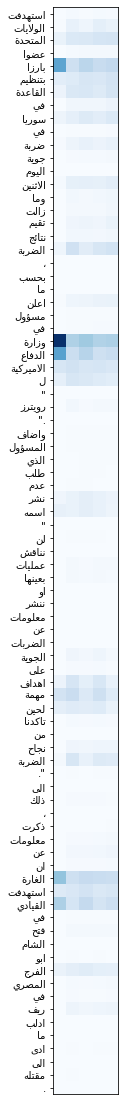

In [86]:
plt.figure(figsize = (20,20))
# plt.title('regularization: {}'.format(regularizations[i]))
prediction, attention = my_model.forward(b[0])
# move to cpu 
# detach from model
# get numpy array
A_to_visualize = attention.cpu().detach().numpy()[0, :, :]
plt.yticks(ticks = np.arange(A_to_visualize.shape[-1]),
           labels=text_reshaped)
plt.xticks([])
plt.imshow(A_to_visualize.T, cmap=plt.cm.Blues)